In [1]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_theme()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from scipy.stats import norm
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from neuralsens import partial_derivatives as ns

#Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.vq import vq
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
from skfuzzy import cmeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
from itertools import combinations

#Profiling
import line_profiler
from line_profiler import LineProfiler
%load_ext line_profiler

from funciones_limpieza import *
from utils_aprendizaje_no_supervisado import * 


# Limpieza y preprocesado csvs Parque MYRTLE

In [2]:
#Convertimos los csvs a dataframes de pandas. El resultado de aplicar la función 'limpieza_csv_plotss_carpeta' es una tupla donde el primer 
#elemento es una lista de dataframes y el segundo una lista con los nombres de estos dataframes
carpeta = '/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/Datos Parque MYRTLE/Plots Myrtle'
dfs_nombres_plots = limpieza_csv_plots_carpeta(carpeta)

/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")
/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")
/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")
/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match len

In [3]:
#Comprobamos que tenemos el mismo número de dataframes, nombres y elementos en la carpeta
archivos = [f for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))]
print(f"En la carpeta {carpeta} tenemos {len(archivos)} archivos")

dataframes = dfs_nombres_plots[0]
print(f"Hay {len(dataframes)} dataframes")

nombres_dfs = dfs_nombres_plots[1]
print(f"Hay {len(nombres_dfs)} nombres de dataframes")

En la carpeta /Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/Datos Parque MYRTLE/Plots Myrtle tenemos 70 archivos
Hay 70 dataframes
Hay 70 nombres de dataframes


### Obtención de la variable delta de temperatura que será la variable objetivo en el problema de detección de fallo por condensación en los inversores

In [4]:
#Función para calcular el delta de temperatura en un dataframe completo

def calculo_delta_temp_dataframe(df):
    """
    Función que dado un dataframe de la lista resultado de la función 'limpieza_csv_plots_carpeta' calcula la columna delta de temperatura para 
    cada registro

    PARÁMETROS
    ----------
    -df: uno de los dataframes de limpieza_csv_plots_carpeta(carpeta)[0]

    DEVUELVE
    --------
    -df: es el dataframe original al que se han añadido las columnas 'T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN' y 'DELTA_TEMP_AMB'
    """
    
    #Calculamos el mínimo de temperatura de los skiips. Si esta es superior o igual a 31ºC tenemos en cuenta este mínimo para el cálculo del
    #delta de temperatura. En caso contrario, tenemos que tener en cuenta las temperaturas del líquido Glicol
    df['T_SKIIP_MIN'] = df[['TBRID11', 'TBRID12', 'TBRID13', 'TBRID21', 'TBRID22', 'TBRID23']].min(axis=1) #axis=1 para que calcule el mínimo por fila

    #Calculamos el valor máximo de las temperaturas de las cabinas de bloques de potencia 1 y 2 (nos ayuda a tener una idea sobre la temperatura
    #externa)
    df['TPOT_CAB_MAX'] = df[['TCAB_POT1', 'TCAB_POT2']].max(axis=1)

    # Calculamos el valor mínimo entre las temperaturas entreda/salida del líquido Glicol (solo se usará este valor si el valor mínimo de los
    #skiips es menor que 31ºC)
    df['T_LIQ_MIN'] = df[['TCOOLINGI', 'TCOOLINGO']].min(axis=1)

    #Calculamos el delta de temperatura según el valor mínimo de los skiips
    df['DELTA_TEMP_AMB'] = np.where(
    df['T_SKIIP_MIN'] >= 31, #condición: se evalúa para cada fila del df y da como resultado una serie booleana (True o False por fila)
    df['T_SKIIP_MIN'] - df['TPOT_CAB_MAX'], #valor que se asigna a DELTA_TEMP_AMB si la condición es True
    df['T_LIQ_MIN'] - df['TPOT_CAB_MAX'] #valor que se asigna si la condición es False
    )

    return df
    

In [5]:
#Aplicamos la función 'calculo_delta_temp_dataframe' a cada dataframe de la lista dataframes
dataframes_con_delta = []
for i in range(len(dataframes)):
    df_aux = calculo_delta_temp_dataframe(dataframes[i])
    dataframes_con_delta.append(df_aux)
dataframes = dataframes_con_delta
#dataframes[0]

In [6]:
#Guardamos estos dataframes en la carpeta '/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/Datos Parque MYRTLE/Plots_con_DeltaTemp'
#carpeta_plots_deltatemp = '/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/Datos Parque MYRTLE/Plots_con_DeltaTemp'
#for i in range(len(dataframes)):
#    dataframes[i].to_csv(f'{carpeta_plots_deltatemp}/{nombres_dfs[i]}.csv', index=False)

### Preprocesado de los dataframes

In [7]:
#Ahora aplicamos preprocesado a los datos: eliminamos valores nulos, columnas no numéricas y realizamos normalización
scaled, scaler = preprocesado_lista_dfs(dataframes, nombres_dfs)
print(f"Hay {len(scaled)} dataframes y arrays preprocesados y normalizados")

#Me quedo con los nombres de los df y arrays para tener trazabilidad de los datos
nombres_dfs_arrays_scaled = list(scaled.keys())
dfs_arrays_scaled = list(scaled.values())
print(f"El número de nombres de dataframes y arrays es {len(nombres_dfs_arrays_scaled)} y de dataframes y arrays es {len(dfs_arrays_scaled)}")

Hay 140 dataframes y arrays preprocesados y normalizados
El número de nombres de dataframes y arrays es 140 y de dataframes y arrays es 140


In [8]:
#Creamos listas independientes para poder distinguir entres dataframes y arrays
nombres_dfs = []
nombres_arrays = []
dfs_plots = []
arrays_plots = []
for i in range(len(nombres_dfs_arrays_scaled)):
    nombre = nombres_dfs_arrays_scaled[i]
    datos = dfs_arrays_scaled[i]
    if "array" in nombre:
        nombres_arrays.append(nombre)
        arrays_plots.append(datos)
    else:
        nombres_dfs.append(nombre)
        dfs_plots.append(datos)
print(f"El número de nombres de dataframes es {len(nombres_dfs)}")
print(f"El número de nombres de arrays es {len(nombres_arrays)}")
print(f"El número de dataframes es {len(dfs_plots)}")
print(f"El número de arrays es {len(arrays_plots)}")

El número de nombres de dataframes es 70
El número de nombres de arrays es 70
El número de dataframes es 70
El número de arrays es 70


In [9]:
#Vemos las variables numéricas de los dataframes que serán sobre las cuales aplicaremos los modelos de clustering
numeric_features = dfs_plots[0].select_dtypes(include=['int64','float64']).columns.tolist()
print(numeric_features)
print(f'Hay {len(numeric_features)} variables numéricas en los dataframes')

['PPC_PMG', 'PPC_QMG', 'PMG_M', 'QMG_M', 'UL1_RMS', 'UL2_RMS', 'UL3_RMS', 'IT1_RMS', 'IT2_RMS', 'IT3_RMS', 'UDC1_FIL', 'UDC2_FIL', 'VPV1_FIL', 'VPV2_FIL', 'TSOC', 'TCCU', 'TEXTERIOR', 'TCAB_AC', 'TCAB_POT1', 'TCAB_POT2', 'TDC_FUSES', 'TBRID11', 'TBRID12', 'TBRID13', 'TBRID21', 'TBRID22', 'TBRID23', 'TCOILIND1', 'TCOILIND2', 'TCOREIND1', 'TCOREIND2', 'TCOOLINGI', 'TCOOLINGO', 'TAIR_INLET', 'TAIR_OUTLET', 'THFILTER', 'DPF_HUM_INT', 'DPF_TEMP_INT', 'T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']
Hay 42 variables numéricas en los dataframes


# Aplicamos PCA (reducción dimensionalidad)

In [9]:
#Para aplicar PCA tenemos que utilizar los arrays y concatenarlos todos en un único array
array_plots = np.vstack(arrays_plots)  # Une los arrays en uno solo
array_plots.size #valores individuales -> 127005060
#array_plots.shape[0] #muestras -> 3023930

127005060

In [10]:
#Aplicamos PCA
pca = PCA(n_components=10, svd_solver='randomized')
X_pca = pca.fit_transform(array_plots)

#N_COMPONENTS = 0.95:
#Este parámetro indica el porcentaje de la varianza total que queremos explicar con los componentes principales. En este caso, estamos 
#pidiendo que el modelo seleccione suficientes componentes para explicar al menos el 95% de la varianza de los datos.
#¿Qué significa?: Imagina que tienes un conjunto de datos con 100 variables (dimensiones). PCA busca las direcciones (componentes) en las que
#los datos tienen más "dispersión" (es decir, donde se concentra la mayor parte de la información). Luego, se seleccionan las primeras 
#componentes principales para representar los datos de manera más compacta. Al especificar n_components=0.95, le dices a PCA que reduzca el 
#número de componentes a los mínimos necesarios para que el 95% de la variabilidad en los datos originales se mantenga.
#¿Por qué es útil?: Esto es útil cuando quieres reducir la dimensionalidad sin perder mucha información importante. El número exacto de 
#componentes no es predefinido, y PCA seleccionará el número mínimo de componentes que cubran ese 95% de varianza.

#FALLO: el número de componentes que se pueden generar no puede exceder el mínimo entre el número de muestras (n_samples) y el número de 
#características (n_features). En este PCA el máximo de componentes que podré generar será 42 y con este número no llegamos a una varianza de 
#0.95 por lo que pruebo con un número explícito de componentes


#SVD_SOLVER = 'RANDOMIZED':
#El parámetro svd_solver controla cómo se calcula la descomposición de los valores singulares (SVD, por sus siglas en inglés), que es el 
#proceso matemático subyacente a PCA.
#En este caso, usamos randomized, que es un algoritmo de SVD aproximado que es mucho más rápido y eficiente en términos de memoria cuando 
#trabajas con grandes conjuntos de datos.
#¿Por qué usar 'randomized'?: El SVD exacto puede ser muy lento y costoso en términos de memoria, especialmente con grandes cantidades de 
#datos. El enfoque aleatorio hace una estimación aproximada del SVD, lo cual es mucho más rápido y sigue siendo efectivo para la mayoría de 
#los casos, especialmente cuando se usa en un gran conjunto de datos.

In [11]:
#Vemos la varianza explicada por estas componentes principales
exp_variance = pd.DataFrame(
    data=pca.explained_variance_ratio_,
    index=['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)],
    columns=['Exp_variance']
)
exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
exp_variance

,Exp_variance,cum_Exp_variance
PC1,0.575931,0.575931
PC2,0.154523,0.730454
PC3,0.078859,0.809313
PC4,0.049144,0.858457
PC5,0.033484,0.891941
PC6,0.019807,0.911747
PC7,0.014668,0.926415
PC8,0.012802,0.939217
PC9,0.009656,0.948873
PC10,0.009528,0.958400


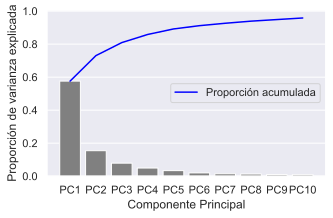

In [13]:
#Gráfica donde podemos ver de forma más visual la varianza explicada por cada componente así como la evolución de la varianza explicada
plt.figure(figsize=(5, 3))

# Gráfico de barras y línea
sns.barplot(data=exp_variance, x=exp_variance.index, y='Exp_variance', color='gray')
sns.lineplot(data=exp_variance, x=exp_variance.index, y='cum_Exp_variance', color='blue', label='Proporción acumulada')

# Etiquetas y leyenda
plt.ylabel('Proporción de varianza explicada')
plt.xlabel('Componente Principal')
plt.legend()

# Guardar antes de mostrar
plt.savefig(os.path.join('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes', 'varianza_explicada_PCA.png'), dpi=300, bbox_inches='tight')

# Mostrar en pantalla
plt.show()

#Considerando 3 PCA conseguimos explicar un 80% de la varianza de los datos y si consideramos más PCA si que aumenta un poco la varianza 
#acumulada pero poco en comparación con el eoaumento en complejidad del problema. Así si consideramos 3 componentes principales, conseguimos
#un buen trade-off entre varianza explicada y complejidad del problema.

### Interpretación de las PCA

In [14]:
#Calcular y visualizar los loadings de las componentes principales en un análisis de PCA (Análisis de Componentes Principales). Los loadings
#son los coeficientes que indican qué tan fuertemente cada característica original (o variable) está relacionada con cada componente 
#principal.

loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=['PC' + str(pca + 1) for pca in range(pca.n_components)], index=numeric_features)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
PPC_PMG,0.880210,-0.211421,0.007353,-0.044943,0.160102,0.013365,0.032623,0.067629,-0.024548,-0.072373
PPC_QMG,0.568969,0.045763,0.652168,0.038064,0.269541,-0.085667,0.113145,0.078244,0.192461,-0.161442
PMG_M,0.936564,-0.178949,0.039371,-0.033711,0.010966,-0.057968,-0.087907,-0.077790,0.100606,0.001560
QMG_M,0.617564,0.075640,0.651715,0.038985,0.120694,-0.150181,-0.046695,-0.069687,0.300971,-0.049374
UL1_RMS,0.522704,0.037380,0.684557,-0.065976,-0.158435,0.038346,0.302278,-0.117569,-0.107019,0.177240
UL2_RMS,0.716501,-0.145188,0.460746,-0.137605,0.070295,0.141981,0.354314,-0.063738,-0.040894,0.082501
UL3_RMS,-0.562152,0.289856,0.605532,0.041196,-0.339977,-0.068063,0.115869,-0.072574,-0.062447,0.061369
IT1_RMS,0.907414,-0.258465,0.002036,-0.064224,0.176280,0.032277,0.085513,0.122474,-0.166544,-0.040624
IT2_RMS,0.907699,-0.257436,0.001131,-0.064311,0.178236,0.031640,0.086045,0.122504,-0.165015,-0.041480
IT3_RMS,0.909198,-0.256058,0.003796,-0.063418,0.163530,0.027959,0.077981,0.115984,-0.176611,-0.035097


In [15]:
#Como nuestro dataset tiene muchas variables, vamos a ver para cada PCA el top 10 variables que más aportan a cada una

def top10_variables_contribuyentes_PCA(loadings, pca):
    """
    Función que calcula las 10 varibles que más contribuyen en cada componente principal.

    PARÁMETROS
    ----------
    -loadings: dataframe con las aportaciones de cada variable en cada PCA
    -pca: objeto de tipo PCA

    DEVUELVE
    --------
    -pca_top10_vars: es un dataframe que contiene las 10 variables que m´s han contribuido en la formación de cada PCA
    """
    # Seleccionar la columna de los loadings para la componente principal especificada
    pca_column = loadings[pca]
    # Ordenar por el valor absoluto de los loadings (de mayor a menor)
    pca_column_abs = pca_column.abs().sort_values(ascending=False)
    # Obtener las 10 variables más contribuyentes
    pca_top10 = pca_column_abs.head(10)
    # Convertir a DataFrame y restablecer el índice
    pca_top10_df = pca_top10.to_frame().reset_index()
    # Extraer solo las variables (primer columna)
    pca_top10_vars = pca_top10_df.iloc[:, 0].tolist()
    
    return pca_top10_vars

In [16]:
pc1_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC1')
pc2_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC2')
pc3_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC3')
pc4_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC4')
pc5_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC5')
pc6_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC6')
pc7_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC7')
pc8_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC8')
pc9_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC9')
pc10_top10_vars = top10_variables_contribuyentes_PCA(loadings, 'PC10')

#Guardamos esta info en un diccionario que será más visual:
top10_variables_pca = {
    'PC1': pc1_top10_vars,
    'PC2': pc2_top10_vars,
    'PC3': pc3_top10_vars,
    'PC4': pc4_top10_vars,
    'PC5': pc5_top10_vars,
    'PC6': pc6_top10_vars,
    'PC7': pc7_top10_vars,
    'PC8': pc8_top10_vars,
    'PC9': pc9_top10_vars,
    'PC10': pc10_top10_vars,
}

# Crear el DataFrame
top10_variables_pca_df = pd.DataFrame(top10_variables_pca)
top10_variables_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,TBRID11,TAIR_INLET,UL1_RMS,TEXTERIOR,VPV2_FIL,TCOOLINGI,UL2_RMS,TCCU,QMG_M,TCOREIND2
1,TBRID22,TSOC,PPC_QMG,THFILTER,VPV1_FIL,T_LIQ_MIN,UL1_RMS,TAIR_INLET,PPC_QMG,TCOREIND1
2,TBRID12,TCAB_POT1,QMG_M,TCAB_POT1,UDC1_FIL,THFILTER,UDC1_FIL,TSOC,IT3_RMS,UL1_RMS
3,T_SKIIP_MIN,TCCU,UL3_RMS,TPOT_CAB_MAX,UDC2_FIL,TEXTERIOR,UDC2_FIL,TCAB_POT1,IT1_RMS,VPV2_FIL
4,TBRID23,TDC_FUSES,UDC2_FIL,TDC_FUSES,UL3_RMS,TCCU,TEXTERIOR,DELTA_TEMP_AMB,IT2_RMS,VPV1_FIL
5,TBRID13,TPOT_CAB_MAX,UDC1_FIL,TCAB_POT2,T_LIQ_MIN,VPV1_FIL,TCOREIND2,IT2_RMS,TCAB_POT1,PPC_QMG
6,TBRID21,TEXTERIOR,UL2_RMS,TCOOLINGI,TCOOLINGI,VPV2_FIL,TCOILIND1,IT1_RMS,TAIR_INLET,UDC1_FIL
7,TCOILIND2,TCAB_POT2,VPV1_FIL,T_LIQ_MIN,PPC_QMG,UDC1_FIL,TCOILIND2,UL1_RMS,VPV1_FIL,UDC2_FIL
8,TCOILIND1,TCAB_AC,VPV2_FIL,TSOC,TDC_FUSES,UDC2_FIL,UL3_RMS,IT3_RMS,VPV2_FIL,THFILTER
9,TCOOLINGO,DELTA_TEMP_AMB,THFILTER,UDC1_FIL,TAIR_INLET,QMG_M,PPC_QMG,UDC1_FIL,UL1_RMS,TCCU


In [17]:
#PARA LA APLICACIÓN DE LOS SIGUIENTES MODELOS VAMOS A CONOSIDERAR LAS 3 PRIMERAS COMPONENTES PRINCIPALES QUE REPRESENTAN EL 80% DE LA 
#VARIABILIDAD DE LOS DATOS DE LOS INVERSORES

In [18]:
#EN EL NOTEBOOK Analisis_PCA vamos a hacer un análisis más en detalle de las variables que más aportan en PC1,PC2,PC3 

# MODELOS CLUSTERING

In [14]:
# Seleccionar las primeras 3 componentes principales
X_pca_3 = X_pca[:, :3] #selecciona todas las filas (:) y las primeras 3 columnas (:3). Así, reduces los datos a un espacio de 3 dimensiones, que son las primeras 3 componentes principales.
#X_pca_3.size #valores individuales (9071790)
X_pca_3.shape[0]

3023930

### K-MEANS

In [15]:
def train_kmeans(X, range_n_clusters):
    """
    Función para entrenar un modelo de k-means calculando la suma de los cuadrados de los errores y el coeficiente de silhouette

    PARÁMETROS
    ----------
    -X: array de numpy que representa el conjunto de datos sobre los que aplicar k-means
    -range_n_clusters: rango de número de cllusteres sobre los que entrenar el modelo

    DEVUELVE
    --------
    -SSQ: suma de los cuadrados de los errores del clustering
    -sil_avg: coeficiente de Silhoouette medio del modelo
    """
    SSQ = []  # Para almacenar la suma de los cuadrados de los errores (Inercia)
    sil_avg = []  # Para almacenar los valores de la puntuación de Silhouette

    for n_clusters in range_n_clusters:
        # Inicializar el modelo KMeans
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init="auto")  
        clusterer.fit(X)  # Ajustar el modelo
        
        cluster_labels = clusterer.labels_  
        SSQ.append(clusterer.inertia_)  
        sil_avg.append(silhouette_score(X, cluster_labels))  
        
        print(f"Entrenado con {n_clusters} clusters")

    return SSQ, sil_avg

In [16]:
#Como implementar el coeficiente de Silhouette en todo mi conjunto de datos es muy costoso voy a probar aplicando simplified silhouette (solo
#calculo este coeficiente sobre una muestra del dataset total)

def simplified_silhouette(X, labels, sample_size=1000):
    """
    Calcula el coeficiente de Silhouette simplificado usando una muestra aleatoria de puntos.

    PARÁMETROS
    -----------
    -X: array de numpy con los datos de entrada
    -labels: etiquetas de los clusters
    -sample_size: número de puntos a muestrear para agilizar el cálculo

    DEVUELVE
    ---------
    -coeficiente de Silhouette simplificado
    
    """
    unique_labels = np.unique(labels)
    sampled_indices = np.random.choice(len(X), min(sample_size, len(X)), replace=False)
    X_sampled = X[sampled_indices]
    labels_sampled = labels[sampled_indices]
    
    return silhouette_score(X_sampled, labels_sampled)

In [17]:
def train_kmeans_simplified_silhouette(X, range_n_clusters, sample_size=1000):
    """
    Función para entrenar un modelo de k-means calculando la suma de los cuadrados de los errores y el coeficiente de silhouette simplificado

    PARÁMETROS
    ----------
    -X: array de numpy que representa el conjunto de datos sobre los que aplicar k-means
    -range_n_clusters: rango de número de cllusteres sobre los que entrenar el modelo
    -sample_size: número de puntos a muestrear para agilizar el cálculo

    DEVUELVE
    --------
    -SSQ: suma de los cuadrados de los errores del clustering
    -sil_avg: coeficiente de Silhoouette simplificado medio del modelo
    """
    SSQ = []  # Para almacenar la suma de los cuadrados de los errores (Inercia)
    sil_avg = []  # Para almacenar los valores de la puntuación de Silueta

    for n_clusters in range_n_clusters:
        # Inicializar el modelo KMeans
        clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  
        clusterer.fit(X)  # Ajustar el modelo
        
        cluster_labels = clusterer.labels_  
        SSQ.append(clusterer.inertia_)  # Inercia
        
        # Usar simplified silhouette con la muestra
        sil_avg.append(simplified_silhouette(X, cluster_labels, sample_size))  
        
        print(f"Entrenado con {n_clusters} clusters")

    return SSQ, sil_avg

In [23]:
#Entreno este modelo de k-means con un rango de k (número de clusters) entre 2 y 10
range_n_clusters = list(range(2, 11))
SSQ_simpl, simpl_sil_avg = train_kmeans_simplified_silhouette(X_pca_3, range_n_clusters)

Entrenado con 2 clusters
Entrenado con 3 clusters
Entrenado con 4 clusters
Entrenado con 5 clusters
Entrenado con 6 clusters
Entrenado con 7 clusters
Entrenado con 8 clusters
Entrenado con 9 clusters
Entrenado con 10 clusters


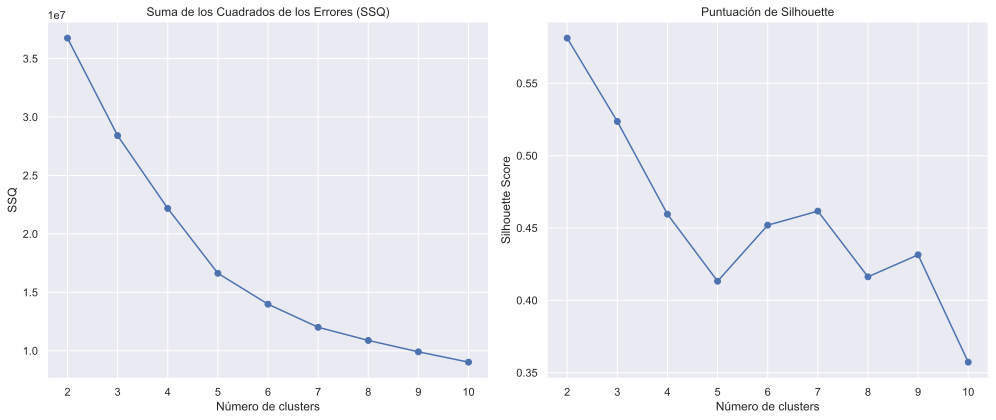

In [57]:
# Graficar la suma de los cuadrados de los errores (SSQ) y la puntuación de Silouhette

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico para la suma de los cuadrados de los errores (SSQ)
ax1.plot(range_n_clusters, SSQ_simpl, marker='o')
ax1.set_title("Suma de los Cuadrados de los Errores (SSQ)")
ax1.set_xlabel("Número de clusters")
ax1.set_ylabel("SSQ")

# Gráfico para la puntuación de Silueta
ax2.plot(range_n_clusters, simpl_sil_avg, marker='o')
ax2.set_title("Puntuación de Silhouette")
ax2.set_xlabel("Número de clusters")
ax2.set_ylabel("Silhouette Score")

# Ajustar la distribución para evitar el solapamiento
plt.tight_layout()

# Guardar la imagen como un archivo
plt.savefig('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/Kmeans_PCA3_RangoClusters2a10.png')  # Especifica el nombre y la ubicación

# Mostrar los gráficos
plt.show()

#Si nos fijamos en SSQ el número óptimo de clusters es 5 mientra que si nos fijamos en Silhouette sería 2

#### K = 2

In [25]:
# Entrenamos k-means con 2 clusters y usando los datos con las 3 primeras PCA

# Definir el número de clusters
k = 2

# Inicializar y entrenar el modelo KMeans
kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)  
kmeans.fit(X_pca_3)

# Obtener etiquetas de los clusters
cluster_labels = kmeans.labels_

# Obtener los centros de los clusters
cluster_centers = kmeans.cluster_centers_

# Muestrear un pequeño porcentaje de los datos para la visualización
sample_size = int(X_pca_3.shape[0] * 1)  # 100% de los datos, puedes ajustar el porcentaje
sampled_indices = np.random.choice(X_pca_3.shape[0], sample_size, replace=False)  # Índices de la muestra
sampled_X = X_pca_3[sampled_indices, :]  # Datos muestreados
sampled_labels = cluster_labels[sampled_indices]  # Etiquetas de los clusters para los datos muestreados

# Número de componentes principales
n_components = X_pca_3.shape[1]

# Generar todos los pares de componentes principales únicos
pairs = list(combinations(range(n_components), 2))

# Crear los subgráficos
fig, axes = plt.subplots(len(pairs), 1, figsize=(6, len(pairs) * 3))

# Si solo hay un par, `axes` será un array de un solo elemento, por lo que aseguramos que sea iterable
if len(pairs) == 1:
    axes = [axes]

# Visualización por pares de componentes principales
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]  # Acceder al subgráfico correspondiente

    # Scatter por clúster para añadir leyenda
    for cluster_id in np.unique(sampled_labels):
        cluster_points = sampled_X[sampled_labels == cluster_id]
        ax.scatter(
            cluster_points[:, i], cluster_points[:, j],
            label=f"Cluster {cluster_id}",
            alpha=0.5,
            s=10
        )

    # Visualización de los centros
    ax.scatter(
        cluster_centers[:, i], cluster_centers[:, j],
        c='red', marker='X', s=80, label="Centroides"
    )

    # Ajustar ejes al rango de los puntos
    ax.set_xlim([sampled_X[:, i].min() - 0.5, sampled_X[:, i].max() + 0.5])
    ax.set_ylim([sampled_X[:, j].min() - 0.5, sampled_X[:, j].max() + 0.5])

    ax.set_title(f"K-means: PC{i+1} vs PC{j+1}")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.legend(loc='upper right', fontsize=8)

# Ajustar disposición y guardar
plt.tight_layout()
plt.savefig('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/KMeans/clusters_kmeans_k2_PCA3.png')
plt.close()

In [24]:
#Calculo coeficiente de Silhouette:
silhouette_kmeans2= simplified_silhouette(X_pca_3, cluster_labels, sample_size=1000)
print(f"El coeficiente de Silhouette para k-means con k = 2 es {silhouette_kmeans2}")

El coeficiente de Silhouette para k-means con k = 2 es 0.5895780095751239


In [43]:
# Saber el valor medio que tienen los centroides de un cluster nos dará una idea intuitiva de los valores que toman para cada PCA los 
# puntos de un cluster

# Print values of the cluster centers
n_clusters = 2
print(cluster_centers) #los centroides están en el espacio de PCA

# Plot the values of the cluster center
for i in range(cluster_centers.shape[1]):
    plt.figure(figsize=(5, 3))
    sns.barplot(x=range(n_clusters), y=cluster_centers[:, i], edgecolor='black', palette='viridis')
    plt.xticks(range(n_clusters))
    plt.xlabel('Cluster')
    plt.ylabel('PC{}'.format(i + 1))
    plt.title('Valores de los centroides para PC{}'.format(i + 1))

    # Ajustar márgenes para que no se corte nada
    plt.tight_layout()

    # Guardar la imagen en lugar de mostrarla
    nombre_archivo = f'/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/Kmeans/Kmeans2_cluster_centers_PC{i+1}.png'
    plt.savefig(nombre_archivo, dpi=300)
    plt.close()



[[-3.43032797  0.2083184  -0.07058005]
 [ 5.86322335 -0.3560643   0.12063762]]


/var/folders/wn/gxtmyy811gg8d_h61xk9hfkm0000gn/T/ipykernel_877/243221205.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(n_clusters), y=cluster_centers[:, i], edgecolor='black', palette='viridis')
/var/folders/wn/gxtmyy811gg8d_h61xk9hfkm0000gn/T/ipykernel_877/243221205.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(n_clusters), y=cluster_centers[:, i], edgecolor='black', palette='viridis')
/var/folders/wn/gxtmyy811gg8d_h61xk9hfkm0000gn/T/ipykernel_877/243221205.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x

In [26]:
# Obtener el número de elementos en cada clúster
cluster_counts = np.bincount(cluster_labels)

# Imprimir el número de elementos en cada clúster
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} elementos")

#Observamos que el cluster 0 tiene más elementos (quizá es el cluster con registros de comportamiento normal)

Cluster 0: 1907212 elementos
Cluster 1: 1116718 elementos


##### Ahora probamos este clustering con los datos de inversores con un funcionamiento a priori normal y uno con comportamiento anómalo

In [27]:
#Vamos a considerar el inversor 34 y el 11 del día 13-02-25. Sabemos que el inversor 11 tuvo fallo de explosión tras congelar

In [30]:
#LECTURA Y PPREPROCESADO INVERSOR 11
#-----------------------------------

carpeta_explosion_congelar = '/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/FalloExplosionTrasCongelarPruebas 13_02_25/inv11' 
dfs_nombres_plots_explosion_congelar = limpieza_csv_plots_carpeta(carpeta_explosion_congelar)
dataframes_explosion_congelar = dfs_nombres_plots_explosion_congelar [0]
nombres_dfs_explosion_congelar  = dfs_nombres_plots_explosion_congelar [1]

scaled_explosion_congelar, scaler_explosion_congelar = preprocesado_lista_dfs(dataframes_explosion_congelar, nombres_dfs_explosion_congelar)
#Me quedo con los nombres de los df y arrays para tener trazabilidad de los datos
nombres_df_arrays_scaled_explosion_congelar = list(scaled_explosion_congelar.keys())
dfs_arrays_scaled_explosion_congelar = list(scaled_explosion_congelar.values())
#Creo listas independientes para poder distinguir entres dfs y arrays
nombres_dfs_explosion_congelar = []
nombres_arrays_explosion_congelar = []
dfs_plots_explosion_congelar = []
arrays_plots_explosion_congelar = []
for i in range(len(nombres_df_arrays_scaled_explosion_congelar)):
    nombre = nombres_df_arrays_scaled_explosion_congelar[i]
    datos = dfs_arrays_scaled_explosion_congelar[i]
    if "array" in nombre:
        nombres_arrays_explosion_congelar.append(nombre)
        arrays_plots_explosion_congelar.append(datos)
    else:
        nombres_dfs_explosion_congelar.append(nombre)
        dfs_plots_explosion_congelar.append(datos)
        
numeric_features_explosion_congelar = dfs_plots_explosion_congelar[0].select_dtypes(include=['int64','float64']).columns.tolist()
print(numeric_features_explosion_congelar)
#Los datos aportados antes de los obtenidos en el parque MYRTLE tienen nueve variables más que tendremos que eliminar para poder aplicar el 
#mismo modelo de clusltering
variables_a_eliminar =  ['PREO',
     'PREI',
     'FAN_INTERNAL_FLOW',
     'FAN_INTERNAL_FB',
     'FAN_COOLER_SP',
     'FAN_COOLER1_FB',
     'FAN_COOLER2_FB',
     'FAN_COOLER3_FB',
     'FAN_COOLER4_FB']
dfs_plots_explosion_congelar[0] = dfs_plots_explosion_congelar[0].drop(variables_a_eliminar, axis=1)
numeric_features_explosion_congelar = dfs_plots_explosion_congelar[0].select_dtypes(include=['int64','float64']).columns.tolist()
print(numeric_features_explosion_congelar == numeric_features) #tenemos las mismas variables

#Para aplicar PCA tenemos que utilizar los arrays y concatenarlos todos en un único array
array_plots_explosion_congelar = np.vstack(arrays_plots_explosion_congelar)  # Une los arrays en uno solo
array_plots_explosion_congelar = array_plots_explosion_congelar[:, :-9]
X_pca_explosion_congelar = pca.fit_transform(array_plots_explosion_congelar)
# Seleccionar las primeras 3 componentes principales
X_pca_3_explosion_congelar = X_pca_explosion_congelar[:, :3] #selecciona todas las filas (:) y las primeras 3 columnas (:3). Así, reduces los datos a un espacio de 3 dimensiones, que son las primeras 3 componentes principales.
X_pca_3_explosion_congelar.size

/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")


['PPC_PMG', 'PPC_QMG', 'PMG_M', 'QMG_M', 'UL1_RMS', 'UL2_RMS', 'UL3_RMS', 'IT1_RMS', 'IT2_RMS', 'IT3_RMS', 'UDC1_FIL', 'UDC2_FIL', 'VPV1_FIL', 'VPV2_FIL', 'TSOC', 'TCCU', 'TEXTERIOR', 'TCAB_AC', 'TCAB_POT1', 'TCAB_POT2', 'TDC_FUSES', 'TBRID11', 'TBRID12', 'TBRID13', 'TBRID21', 'TBRID22', 'TBRID23', 'TCOILIND1', 'TCOILIND2', 'TCOREIND1', 'TCOREIND2', 'TCOOLINGI', 'TCOOLINGO', 'TAIR_INLET', 'TAIR_OUTLET', 'THFILTER', 'DPF_HUM_INT', 'DPF_TEMP_INT', 'PREO', 'PREI', 'FAN_INTERNAL_FLOW', 'FAN_INTERNAL_FB', 'FAN_COOLER_SP', 'FAN_COOLER1_FB', 'FAN_COOLER2_FB', 'FAN_COOLER3_FB', 'FAN_COOLER4_FB', 'T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']
True


129573

In [34]:
total_elements = X_pca_3_explosion_congelar.shape[0]

In [35]:
# Aplicar el modelo KMeans para predecir los clusters de los nuevos datos
clusters_predichos_explosion_congelar = kmeans.predict(X_pca_3_explosion_congelar)  # Usamos los datos ya transformados

# Número de elementos en cada cluster
cluster_counts = np.bincount(clusters_predichos_explosion_congelar)

# Mostrar el número de elementos en cada clúster
for cluster_id, count in enumerate(cluster_counts):
    percentage = (count / total_elements) * 100
    print(f"Cluster {cluster_id}: {count} elementos ({percentage:.2f}%)")

#Tenemos el doble de elementos en el cluster 0 que en el 1

Cluster 0: 28317 elementos (65.56%)
Cluster 1: 14874 elementos (34.44%)


In [36]:
# Establece la carpeta donde guardar las imágenes
ruta_guardado = "/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/Kmeans"
# Visualización de la distribución de los clusters de los registros de este inversor
sample_size = int(X_pca_3_explosion_congelar.shape[0] * 1)  # puedo cambiar 1 por el porcentaje que quiera
sampled_indices = np.random.choice(X_pca_3_explosion_congelar.shape[0], sample_size, replace=False)  # Indices de la muestra
sampled_X = X_pca_3_explosion_congelar[sampled_indices, :]  # Datos muestreados
sampled_labels = clusters_predichos_explosion_congelar[sampled_indices]  # Etiquetas de los clusters para los datos muestreados

# Número de componentes principales
n_components = X_pca_3_explosion_congelar.shape[1]

# Generar todos los pares de componentes principales únicos
pairs = list(combinations(range(n_components), 2))

# Crear los subgráficos
fig, axes = plt.subplots(len(pairs), 1, figsize=(6, len(pairs) * 3))

# Si solo hay un par, `axes` será un array de un solo elemento, por lo que aseguramos que sea iterable
if len(pairs) == 1:
    axes = [axes]

# Definir un conjunto de colores discretos (por ejemplo, 'tab10' tiene hasta 10 colores)
colors = cm.tab10.colors

# Crear un diccionario de colores para cada cluster
cluster_colors = {cluster_id: colors[cluster_id % len(colors)] for cluster_id in np.unique(sampled_labels)}

# Crear los gráficos para cada par de componentes principales
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]  # Acceder al subgráfico correspondiente
    
    # Visualización de todos los puntos usando scatter, color según el cluster
    for cluster_id in np.unique(sampled_labels):
        cluster_points = sampled_X[sampled_labels == cluster_id]
        ax.scatter(cluster_points[:, i], cluster_points[:, j], 
                   color=cluster_colors[cluster_id], alpha=0.5, s=10, label=f'Cluster {cluster_id}')
    
    # Visualizar los centroides en este par de componentes
    ax.scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], 
               c='red', marker='X', s=80, label="Centroides", zorder=5)
    
    # Establecer límites dinámicos para mostrar todos los puntos y centroides
    ax.set_xlim([sampled_X[:, i].min() - 1, sampled_X[:, i].max() + 1])
    ax.set_ylim([sampled_X[:, j].min() - 1, sampled_X[:, j].max() + 1])
    
    ax.set_title(f"PC{i+1} vs PC{j+1}")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    
    # Añadir leyenda para los colores de los clusters
    ax.legend(loc='upper right', fontsize=8, title="Clústeres")
    
    # Añadir leyenda para los centroides
    ax.scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], 
               c='red', marker='X', s=80, label="Centroides", zorder=5)

# Ajustar la disposición de los subgráficos
plt.tight_layout()

# Guardar la figura
nombre_archivo = "DistribucionClusters_Kmeans2_inv11explcongelar.png"  # El nombre que le des al archivo
ruta_completa = os.path.join(ruta_guardado, nombre_archivo)
plt.savefig(ruta_completa, dpi=300)  # Guardar la imagen en la ruta especificada

# Mostrar la figura
plt.close()


In [38]:
#LECTURA Y PPREPROCESADO INVERSOR 34
#-----------------------------------

carpeta_inv34_130225 = '/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/FalloExplosionTrasCongelarPruebas 13_02_25/inv34'  
dfs_nombres_plots_inv34_130225 = limpieza_csv_plots_carpeta(carpeta_inv34_130225)
dataframes_inv34_130225 = dfs_nombres_plots_inv34_130225[0]
nombres_dfs_inv34_130225  = dfs_nombres_plots_inv34_130225[1]

scaled_inv34_130225, scaler_inv34_130225 = preprocesado_lista_dfs(dataframes_inv34_130225, nombres_dfs_inv34_130225)
#Me quedo con los nombres de los df y arrays para tener trazabilidad de los datos
nombres_df_arrays_scaled_inv34_130225 = list(scaled_inv34_130225.keys())
dfs_arrays_scaled_inv34_130225 = list(scaled_inv34_130225.values())
#Creo listas independientes para poder distinguir entres dfs y arrays
nombres_dfs_inv34_130225 = []
nombres_arrays_inv34_130225 = []
dfs_plots_inv34_130225 = []
arrays_plots_inv34_130225 = []
for i in range(len(nombres_df_arrays_scaled_inv34_130225)):
    nombre = nombres_df_arrays_scaled_inv34_130225[i]
    datos = dfs_arrays_scaled_inv34_130225[i]
    if "array" in nombre:
        nombres_arrays_inv34_130225.append(nombre)
        arrays_plots_inv34_130225.append(datos)
    else:
        nombres_dfs_inv34_130225.append(nombre)
        dfs_plots_inv34_130225.append(datos)
        
numeric_features_inv34_130225 = dfs_plots_inv34_130225[0].select_dtypes(include=['int64','float64']).columns.tolist()
print(numeric_features_inv34_130225)
#Los datos aportados antes de los obtenidos en el parque MYRTLE tienen nueve variables más que tendremos que eliminar para poder aplicar el 
#mismo modelo de clusltering
variables_a_eliminar =  ['PREO',
     'PREI',
     'FAN_INTERNAL_FLOW',
     'FAN_INTERNAL_FB',
     'FAN_COOLER_SP',
     'FAN_COOLER1_FB',
     'FAN_COOLER2_FB',
     'FAN_COOLER3_FB',
     'FAN_COOLER4_FB']
dfs_plots_inv34_130225[0] = dfs_plots_inv34_130225[0].drop(variables_a_eliminar, axis=1)
numeric_features_inv34_130225 = dfs_plots_inv34_130225[0].select_dtypes(include=['int64','float64']).columns.tolist()
print(numeric_features_inv34_130225 == numeric_features) #tenemos las mismas variables

#Para aplicar PCA tenemos que utilizar los arrays y concatenarlos todos en un único array
array_plots_inv34_130225 = np.vstack(arrays_plots_inv34_130225)  # Une los arrays en uno solo
array_plots_inv34_130225 = array_plots_inv34_130225[:, :-9]
X_pca_inv34_130225 = pca.fit_transform(array_plots_inv34_130225)
# Seleccionar las primeras 3 componentes principales
X_pca_3_inv34_130225 = X_pca_inv34_130225[:, :3] #selecciona todas las filas (:) y las primeras 3 columnas (:3). Así, reduces los datos a un espacio de 3 dimensiones, que son las primeras 3 componentes principales.
X_pca_3_inv34_130225.size

/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")


['PPC_PMG', 'PPC_QMG', 'PMG_M', 'QMG_M', 'UL1_RMS', 'UL2_RMS', 'UL3_RMS', 'IT1_RMS', 'IT2_RMS', 'IT3_RMS', 'UDC1_FIL', 'UDC2_FIL', 'VPV1_FIL', 'VPV2_FIL', 'TSOC', 'TCCU', 'TEXTERIOR', 'TCAB_AC', 'TCAB_POT1', 'TCAB_POT2', 'TDC_FUSES', 'TBRID11', 'TBRID12', 'TBRID13', 'TBRID21', 'TBRID22', 'TBRID23', 'TCOILIND1', 'TCOILIND2', 'TCOREIND1', 'TCOREIND2', 'TCOOLINGI', 'TCOOLINGO', 'TAIR_INLET', 'TAIR_OUTLET', 'THFILTER', 'DPF_HUM_INT', 'DPF_TEMP_INT', 'PREO', 'PREI', 'FAN_INTERNAL_FLOW', 'FAN_INTERNAL_FB', 'FAN_COOLER_SP', 'FAN_COOLER1_FB', 'FAN_COOLER2_FB', 'FAN_COOLER3_FB', 'FAN_COOLER4_FB', 'T_SKIIP_MIN', 'TPOT_CAB_MAX', 'T_LIQ_MIN', 'DELTA_TEMP_AMB']
True


129597

In [39]:
total_elements = X_pca_3_inv34_130225.shape[0]

In [40]:
# Aplicar el modelo KMeans para predecir los clusters de los nuevos datos
clusters_predichos_inv34_130225 = kmeans.predict(X_pca_3_inv34_130225)  # Usamos los datos ya transformados

# Número de elementos en cada cluster
cluster_counts = np.bincount(clusters_predichos_inv34_130225)

# Mostrar el número de elementos en cada clúster
for cluster_id, count in enumerate(cluster_counts):
    percentage = (count / total_elements) * 100
    print(f"Cluster {cluster_id}: {count} elementos ({percentage:.2f}%)")

#En este caso tenemos más del doble de registros en el cluster 0 que en el 1 lo que respalda la hipótesis de que el cluster 0 es el de 
#registros de comportamiento normal

Cluster 0: 26639 elementos (61.67%)
Cluster 1: 16560 elementos (38.33%)


In [41]:
# Establece la carpeta donde guardar las imágenes
ruta_guardado = "/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/Kmeans"
# Visualización de la distribución de los clusters de los registros de este inversor
sample_size = int(X_pca_3_inv34_130225.shape[0] * 1)  # puedo cambiar 1 por el porcentaje que quiera
sampled_indices = np.random.choice(X_pca_3_inv34_130225.shape[0], sample_size, replace=False)  # Indices de la muestra
sampled_X = X_pca_3_inv34_130225[sampled_indices, :]  # Datos muestreados
sampled_labels = clusters_predichos_inv34_130225[sampled_indices]  # Etiquetas de los clusters para los datos muestreados

# Número de componentes principales
n_components = X_pca_3_inv34_130225.shape[1]

# Generar todos los pares de componentes principales únicos
pairs = list(combinations(range(n_components), 2))

# Crear los subgráficos
fig, axes = plt.subplots(len(pairs), 1, figsize=(6, len(pairs) * 3))

# Si solo hay un par, `axes` será un array de un solo elemento, por lo que aseguramos que sea iterable
if len(pairs) == 1:
    axes = [axes]

# Definir un conjunto de colores discretos (por ejemplo, 'tab10' tiene hasta 10 colores)
colors = cm.tab10.colors

# Crear un diccionario de colores para cada cluster
cluster_colors = {cluster_id: colors[cluster_id % len(colors)] for cluster_id in np.unique(sampled_labels)}

# Crear los gráficos para cada par de componentes principales
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]  # Acceder al subgráfico correspondiente
    
    # Visualización de todos los puntos usando scatter, color según el cluster
    for cluster_id in np.unique(sampled_labels):
        cluster_points = sampled_X[sampled_labels == cluster_id]
        ax.scatter(cluster_points[:, i], cluster_points[:, j], 
                   color=cluster_colors[cluster_id], alpha=0.5, s=10, label=f'Cluster {cluster_id}')
    
    # Visualizar los centroides en este par de componentes
    ax.scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], 
               c='red', marker='X', s=80, label="Centroides", zorder=5)
    
    # Establecer límites dinámicos para mostrar todos los puntos y centroides
    ax.set_xlim([sampled_X[:, i].min() - 1, sampled_X[:, i].max() + 1])
    ax.set_ylim([sampled_X[:, j].min() - 1, sampled_X[:, j].max() + 1])
    
    ax.set_title(f"PC{i+1} vs PC{j+1}")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    
    # Añadir leyenda para los colores de los clusters
    ax.legend(loc='upper right', fontsize=8, title="Clústeres")
    
    # Añadir leyenda para los centroides
    ax.scatter(kmeans.cluster_centers_[:, i], kmeans.cluster_centers_[:, j], 
               c='red', marker='X', s=80, label="Centroides", zorder=5)

# Ajustar la disposición de los subgráficos
plt.tight_layout()

# Guardar la figura
nombre_archivo = "DistribucionClusters_Kmeans2_inv34Dia130225.png"  # El nombre que le des al archivo
ruta_completa = os.path.join(ruta_guardado, nombre_archivo)
plt.savefig(ruta_completa, dpi=300)  # Guardar la imagen en la ruta especificada

# Mostrar la figura
plt.close()
